In [1]:
import h5py
import os, sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
PATH="/wynton/home/ahituv/fongsl/nullomers/bin-lock/gapdh_pred/chromatin-profiles-hdf5"

GAPDH = "gapdh.2048_predictions.h5"
NULL = "gapdh.2048.100.14mers_predictions.h5"

COLNAMES = "/wynton/home/ahituv/fongsl/bin/sei-framework/seq_prediction_columns.txt"

# functions

In [2]:
def readHdF5(filename, path):
    """
    read hdf5 file, dataset
    
    input
        filename (str) - name of hdf5 results
        path (str) - abs path to directory
        
    require 
        h5py
        
    method 
        1. assemble file
        2. read file
        3. get dataset

    return
        file, data
    
    """
    #1
    file = os.path.join(path, filename) 
    #2
    f = h5py.File(file, 'r')
    
    #3
    dset = f['data']

    return f, dset

def getColNames():
    
    """
    return list of 21097 colnames corresponding to sei prediction features
    
    input
        none
    method 
        1. make a list for the column names
        2. open the colnames file 
        3. append name to column name list
    
    return
        colnames (list) - list of column names
    """
    
    #1
    colnames = []
    
    #2
    COLNAMES = "/wynton/home/ahituv/fongsl/bin/sei-framework/seq_prediction_columns.txt"
    with open(COLNAMES, "r") as reader:
        for line in reader:
            #3
            colnames.append(line.strip("\n"))
            
    return colnames

def arrayToDF(dset):
    
    df = pd.DataFrame(np.vstack(dset))
    print(df.shape)
    df.columns = getColNames()
    
    return df.T.reset_index()

# read GAPDH 

In [5]:
f, dset = readHdF5(GAPDH,PATH)

gdf = arrayToDF(dset)

gdf.head()

(1, 21907)


,index,0
0,HeLa_Epithelium_Cervix|BTAF1|ID:1,0.000037
1,H9_Embryonic_Stem_Cell_Embryo|EOMES|ID:1006,0.081906
2,H9_Embryonic_Stem_Cell_Embryo|EP300|ID:1007,0.039591
3,H9_Embryonic_Stem_Cell_Embryo|FOXH1|ID:1010,0.040555
4,H9_Embryonic_Stem_Cell_Embryo|FOXH1|ID:1011,0.008655


# read nullomer sequences

In [6]:
nf, ndset = readHdF5(NULL,PATH)

ndf = arrayToDF(ndset)

# adjust columns by +1, so col 0 can be baseline
new_cols = ["index"]+[i+1 for i in ndf.columns[1:]] 

ndf.columns = new_cols

ndf.head()

(100, 21907)


,index,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,HeLa_Epithelium_Cervix|BTAF1|ID:1,0.000030,0.000036,0.000032,0.000042,0.000039,0.000031,0.000036,0.000027,0.000042,...,0.000035,0.000033,0.000045,0.000036,0.000032,0.000026,0.000034,0.000035,0.000030,0.000040
1,H9_Embryonic_Stem_Cell_Embryo|EOMES|ID:1006,0.078857,0.086628,0.094685,0.087395,0.095155,0.061916,0.086760,0.112822,0.110946,...,0.087383,0.127462,0.106863,0.150618,0.062668,0.099990,0.083978,0.100176,0.080410,0.146050
2,H9_Embryonic_Stem_Cell_Embryo|EP300|ID:1007,0.032125,0.041583,0.041763,0.042221,0.040941,0.036079,0.046108,0.050556,0.048988,...,0.050965,0.043484,0.047312,0.043749,0.037611,0.034143,0.037448,0.046526,0.034384,0.068642
3,H9_Embryonic_Stem_Cell_Embryo|FOXH1|ID:1010,0.034712,0.034187,0.041331,0.034663,0.041338,0.026371,0.034494,0.049345,0.046700,...,0.039309,0.050859,0.043499,0.065957,0.032115,0.047035,0.037785,0.043902,0.038809,0.056456
4,H9_Embryonic_Stem_Cell_Embryo|FOXH1|ID:1011,0.006405,0.007042,0.007291,0.006315,0.011099,0.006513,0.006648,0.008114,0.008274,...,0.009359,0.008088,0.011900,0.009294,0.008545,0.009523,0.007139,0.008826,0.008726,0.014221


# merge control and nullomer data

In [7]:
df = pd.merge(gdf, ndf, on="index")

## melt data into long-form. 
- 0 is control

In [8]:
a = pd.melt(df, id_vars="index")

a.head()

,index,variable,value
0,HeLa_Epithelium_Cervix|BTAF1|ID:1,0,0.000037
1,H9_Embryonic_Stem_Cell_Embryo|EOMES|ID:1006,0,0.081906
2,H9_Embryonic_Stem_Cell_Embryo|EP300|ID:1007,0,0.039591
3,H9_Embryonic_Stem_Cell_Embryo|FOXH1|ID:1010,0,0.040555
4,H9_Embryonic_Stem_Cell_Embryo|FOXH1|ID:1011,0,0.008655


# prediction value distribution - most are zero. 

<Axes: xlabel='value', ylabel='Percent'>

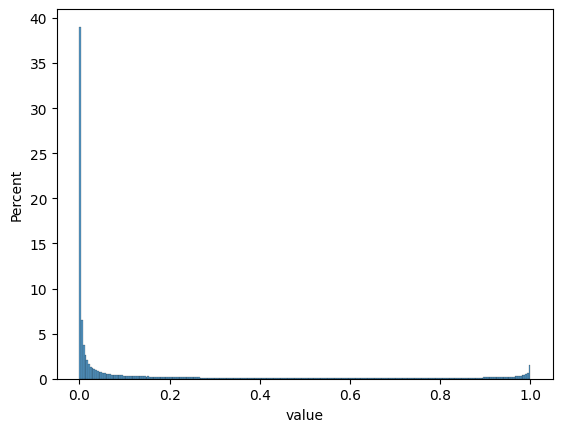

In [9]:
sns.histplot(a["value"].sample(frac=0.5), stat="percent")

# Find k562
- median peak prediction has to be > 0.1

## subset dataframe by cell line

In [10]:
#pred_name = "H9_Embryonic_Stem_Cell_Embryo|EOMES|ID:1006"
CL = "K562"

cldf = a.loc[a["index"].str.contains(CL)]  # get cell-type specific dataframe to query. 

cldf.head()

,index,variable,value
329,K562_Erythroblast_Bone_Marrow|E2F6|ID:1978,0,0.068167
330,K562_Erythroblast_Bone_Marrow|EGR1|ID:1982,0,0.000868
331,K562_Erythroblast_Bone_Marrow|FOS|ID:1990,0,0.002692
332,K562_Erythroblast_Bone_Marrow|FOS|ID:1991,0,0.001211
333,K562_Erythroblast_Bone_Marrow|FOS|ID:1992,0,0.000445


In [11]:
cldf.head()

,index,variable,value
329,K562_Erythroblast_Bone_Marrow|E2F6|ID:1978,0,0.068167
330,K562_Erythroblast_Bone_Marrow|EGR1|ID:1982,0,0.000868
331,K562_Erythroblast_Bone_Marrow|FOS|ID:1990,0,0.002692
332,K562_Erythroblast_Bone_Marrow|FOS|ID:1991,0,0.001211
333,K562_Erythroblast_Bone_Marrow|FOS|ID:1992,0,0.000445


## parse prediction tracks. 
- if median prediction is > 0.1 probability or standard deviation >0.1

In [33]:
def parseSeiFeatures(df, mean_val, sd_val):

    """
    collect a list of features, dictionary of mean and SD values to follow up on
        - features have specific mean, or standard deviation
    """
    lookup, collection = [], {}
    
    for pred_name in df["index"].unique():
    
        # get prediction values for feature
        test = df.loc[df["index"]==pred_name]

        # get baselien value
        baseline = test.loc[test["variable"]==0, "value"].iloc[0]
        
        # get CL, feature, source
        CL, feature, source = pred_name.split("|")

        collection[pred_name] = (test["value"].mean(), test["value"].std())

        # filter, if mean pred > 0.2 and stdev >=0.05
        
        if test["value"].mean()>mean_val and test["value"].std()>=sd_val:
            #print( CL, feature,"\n", test.describe(),"\n", baseline)
            lookup.append(pred_name) # add to the look-up list

    return lookup, collection

## set mean, std threshold

In [34]:
mean_val, sd_val = 0.1, 0.05

lookup, collection = parseSeiFeatures(cldf, mean_val, sd_val)

mean_var=pd.DataFrame(collection.items())

In [35]:
mean_var["mean"] = mean_var[1].apply(lambda x: x[0])
mean_var["st"] = mean_var[1].apply(lambda x: x[1])

<Axes: xlabel='mean', ylabel='st'>

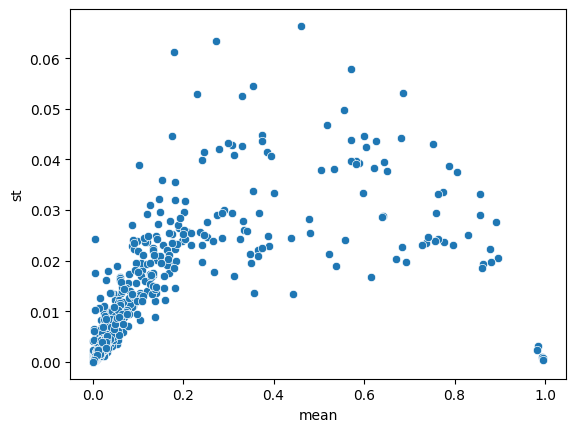

In [36]:
sns.scatterplot(x="mean", y="st", data=mean_var)

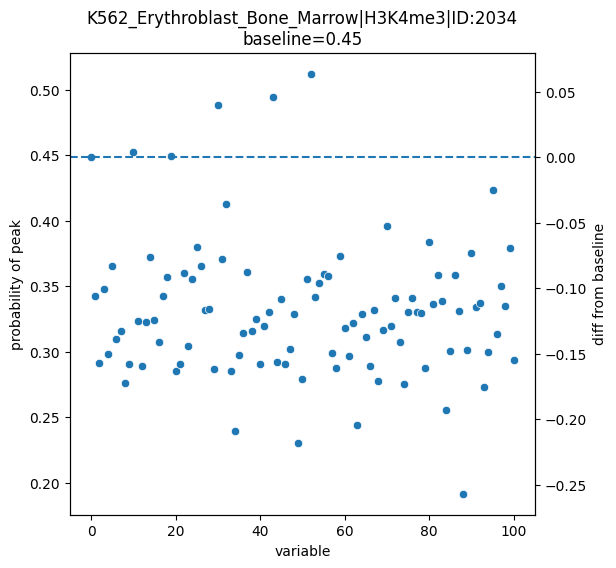

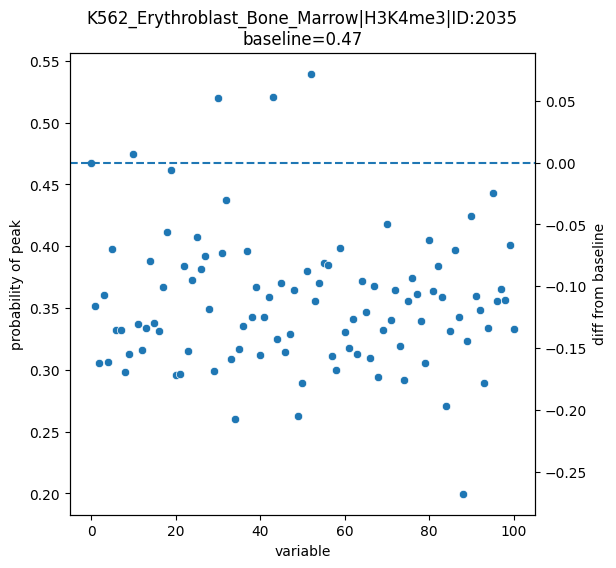

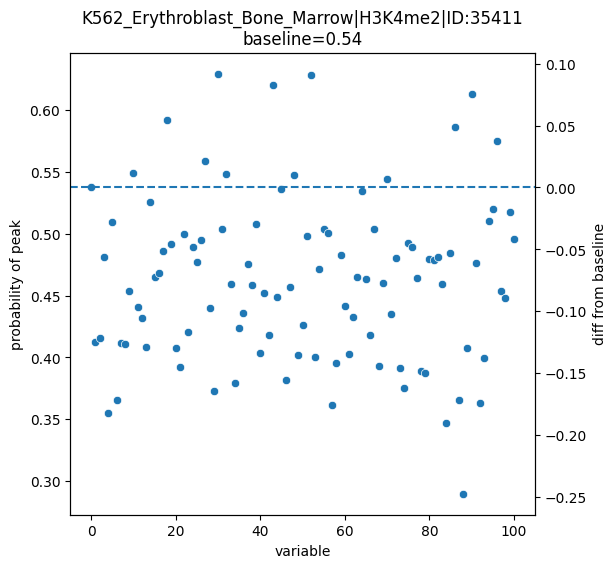

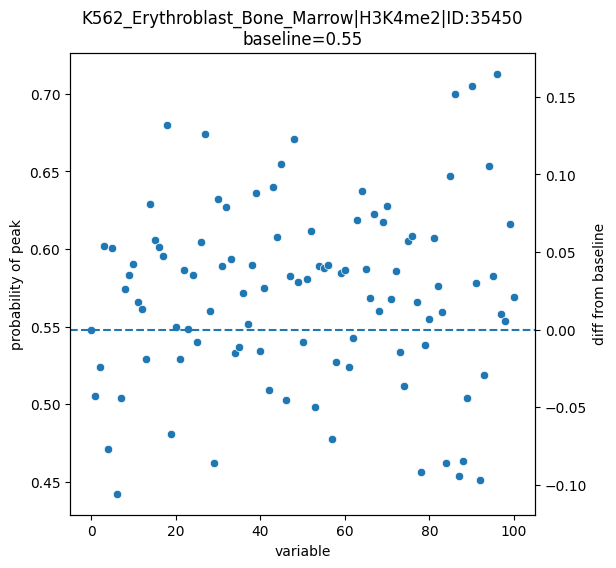

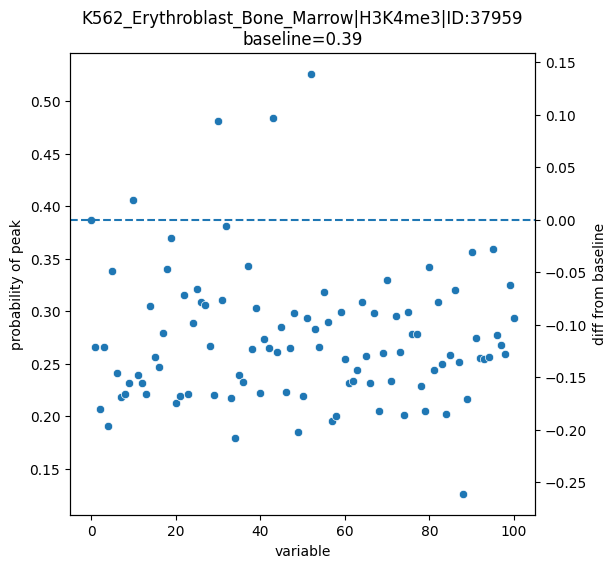

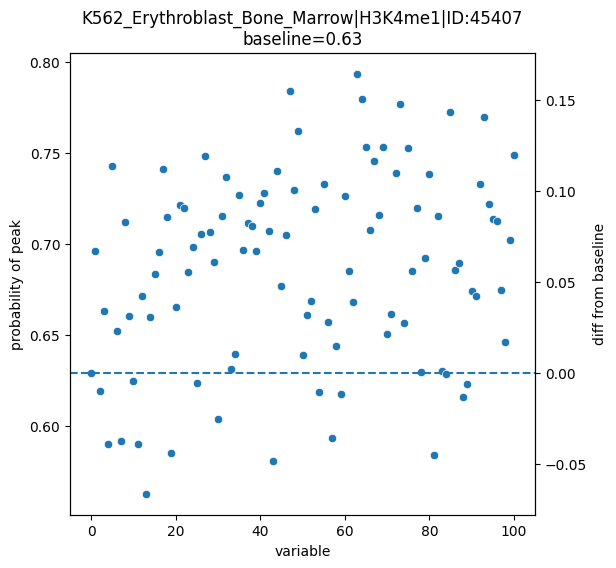

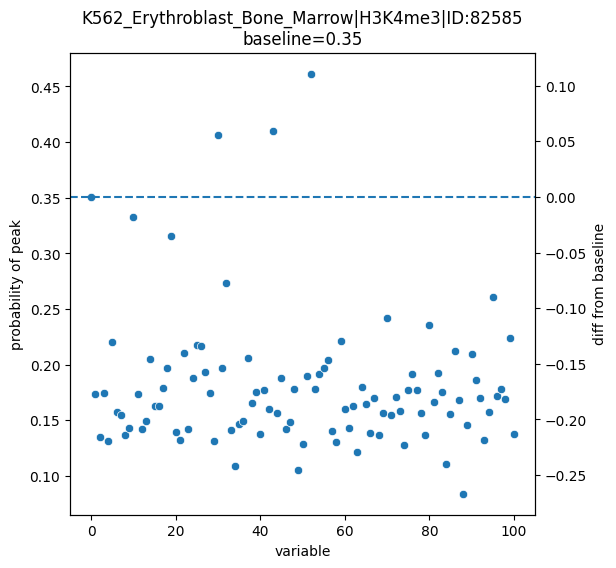

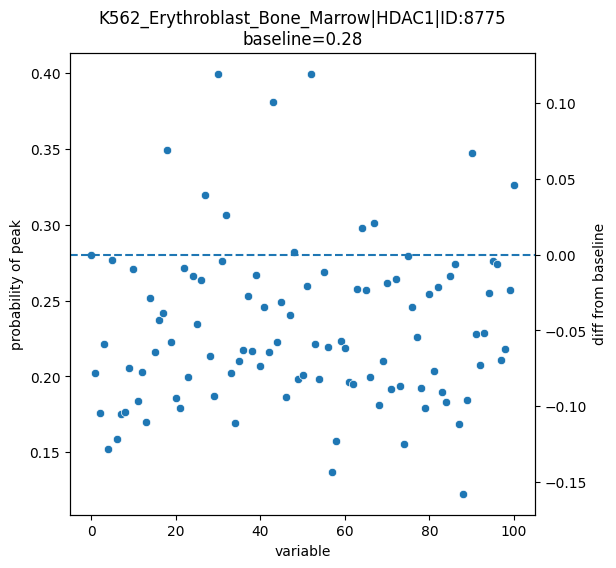

In [39]:
for pred_name in lookup:
    test = cldf.loc[cldf["index"]==pred_name].copy()
    baseline = test.loc[test["variable"]==0, "value"].iloc[0]
    test["diff"] = (baseline - test["value"])*-1
    x, y= "variable", "value"
    data=test

    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(x=x,y=y,data=data)
    ax.set(
        title=pred_name +f"\nbaseline={round(baseline, 2)}",
        ylabel = f"probability of peak"
    )
    ax.axhline(baseline, ls = "--")
    ax2=ax.twinx()
    y= "diff"
    sns.scatterplot(x=x,y=y,data=data, ax=ax2, color="grey", alpha=0)
    
    ax2.set(
        ylabel = f"diff from baseline"
    )

## for all datasets w/ H3K4me3 in k562, is there a correlation between direction/effect size across nullomers?